In [11]:
import os
import numpy as np
import pandas as pd
from astropy.coordinates import Angle
import astropy.units as u
from tess_stars2px import tess_stars2px_function_entry
import tessreduce as tr

In [15]:
# Stack first dimension (from different sectors)

import numpy as np
import os

name = '2019ahk'
dir_path = f'data/lightcurves/{name}'
sector = 62

# Find the first file that contains "sec63"
target_file = next(
    (f for f in os.listdir(dir_path) if f'sec{sector}' in f and f.endswith('.npz')),
    None
)

if target_file is None:
    raise FileNotFoundError(f"No file containing 'sec{sector}' found in the directory.")

file_path = os.path.join(dir_path, target_file)

# Load the .npz file
with np.load(file_path) as data:
    lightcurve_arr = data[data.files[0]]  # adjust key if necessary

print(f"Loaded file: {target_file}")
print(lightcurve_arr.shape)

Loaded file: ra105.04810833333333_dec-66.04003888888889_sec62.npz
(10811, 3)


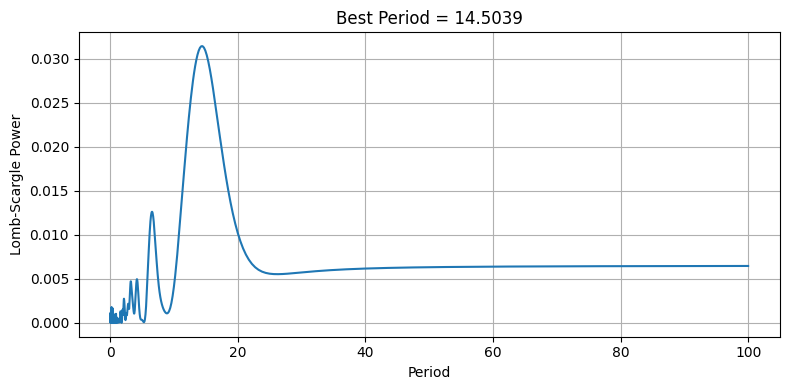

In [8]:
import numpy as np
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt

# Assuming lightcurve_arr has columns: time, flux, flux_error
time = lightcurve_arr[:, 0]
flux = lightcurve_arr[:, 1]
flux_err = lightcurve_arr[:, 2]

# Clean the data: remove any non-finite or invalid error values
mask = (
    np.isfinite(time) &
    np.isfinite(flux) &
    np.isfinite(flux_err) &
    (flux_err > 0)
)
time = time[mask]
flux = flux[mask]
flux_err = flux_err[mask]

# If flux_err is still problematic or too small, fallback to no errors
use_errors = len(flux_err) > 0 and np.all(flux_err > 0)

# Define frequency grid (adjust if needed)
frequency = np.linspace(0.01, 10, 10000)  # in cycles per unit time

# Run Lomb-Scargle
if use_errors:
    ls = LombScargle(time, flux, flux_err)
else:
    ls = LombScargle(time, flux)

power = ls.power(frequency)

# Clean power array to avoid NaNs
power = np.nan_to_num(power, nan=0.0)

# Find best period
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency

# Plot periodogram
plt.figure(figsize=(8, 4))
plt.plot(1 / frequency, power)
plt.xlabel("Period")
plt.ylabel("Lomb-Scargle Power")
plt.title(f"Best Period = {best_period:.4f}")
plt.grid(True)
plt.tight_layout()
plt.show()


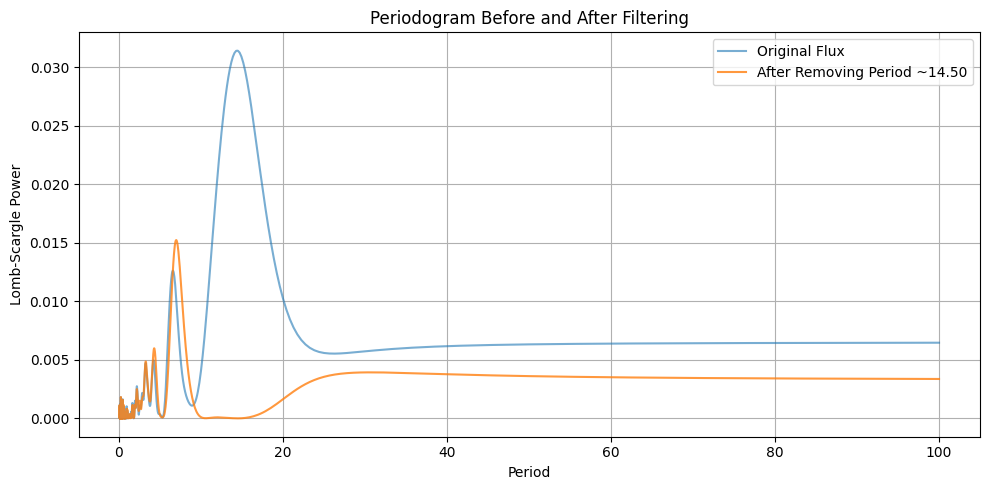

In [9]:
import numpy as np
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt

# --- Prepare and clean data ---
time = lightcurve_arr[:, 0]
flux = lightcurve_arr[:, 1]
flux_err = lightcurve_arr[:, 2]

mask = (
    np.isfinite(time) &
    np.isfinite(flux) &
    np.isfinite(flux_err) &
    (flux_err > 0)
)
time = time[mask]
flux = flux[mask]
flux_err = flux_err[mask]

# --- Original Lomb-Scargle (with or without error) ---
use_errors = np.all(flux_err > 0)
ls = LombScargle(time, flux, flux_err) if use_errors else LombScargle(time, flux)

frequency = np.linspace(0.01, 10, 10000)
power = ls.power(frequency)
power = np.nan_to_num(power)

# --- Find dominant period ---
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency

# --- Subtract the best-fit sinusoid to get residuals ---
model_flux = ls.model(time, best_frequency)
residual_flux = flux - model_flux

# --- Re-run Lomb-Scargle on residuals ---
ls_resid = LombScargle(time, residual_flux, flux_err) if use_errors else LombScargle(time, residual_flux)
power_resid = ls_resid.power(frequency)
power_resid = np.nan_to_num(power_resid)

# --- Plot original + residual periodogram ---
plt.figure(figsize=(10, 5))
plt.plot(1 / frequency, power, label='Original Flux', alpha=0.6)
plt.plot(1 / frequency, power_resid, label='After Removing Period ~{:.2f}'.format(best_period), alpha=0.8)
plt.xlabel("Period")
plt.ylabel("Lomb-Scargle Power")
plt.title("Periodogram Before and After Filtering")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


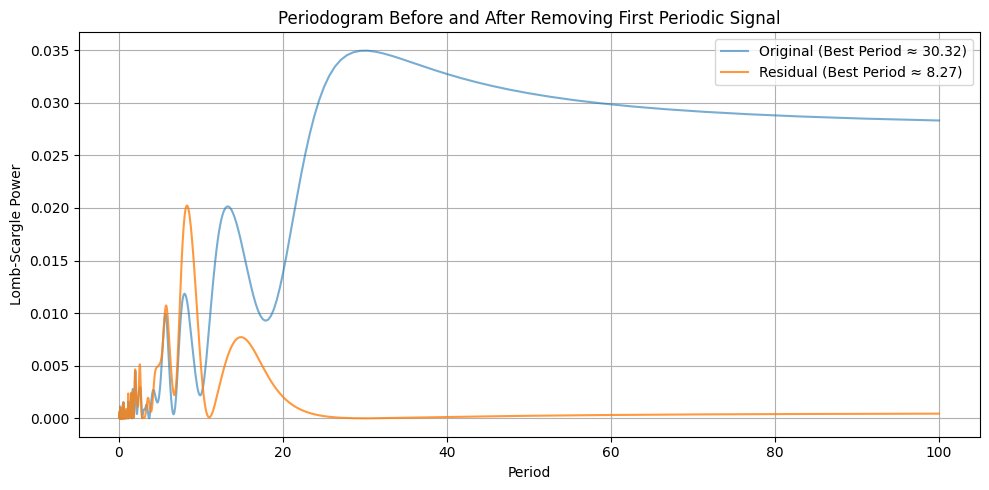

In [13]:
import numpy as np
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt

# --- Prepare and clean data ---
time = lightcurve_arr[:, 0]
flux = lightcurve_arr[:, 1]
flux_err = lightcurve_arr[:, 2]

mask = (
    np.isfinite(time) &
    np.isfinite(flux) &
    np.isfinite(flux_err) &
    (flux_err > 0)
)
time = time[mask]
flux = flux[mask]
flux_err = flux_err[mask]

# --- Original Lomb-Scargle ---
use_errors = np.all(flux_err > 0)
ls = LombScargle(time, flux, flux_err) if use_errors else LombScargle(time, flux)

frequency = np.linspace(0.01, 10, 10000)
power = ls.power(frequency)
power = np.nan_to_num(power)

# --- Best period before subtraction ---
best_freq_1 = frequency[np.argmax(power)]
best_period_1 = 1 / best_freq_1

# --- Subtract best-fit sinusoid ---
model_flux = ls.model(time, best_freq_1)
residual_flux = flux - model_flux

# --- Lomb-Scargle on residuals ---
ls_resid = LombScargle(time, residual_flux, flux_err) if use_errors else LombScargle(time, residual_flux)
power_resid = ls_resid.power(frequency)
power_resid = np.nan_to_num(power_resid)

# --- Best period after subtraction ---
best_freq_2 = frequency[np.argmax(power_resid)]
best_period_2 = 1 / best_freq_2

# --- Plot both periodograms ---
plt.figure(figsize=(10, 5))
plt.plot(1 / frequency, power, label=f'Original (Best Period ≈ {best_period_1:.2f})', alpha=0.6)
plt.plot(1 / frequency, power_resid, label=f'Residual (Best Period ≈ {best_period_2:.2f})', alpha=0.8)
plt.xlabel("Period")
plt.ylabel("Lomb-Scargle Power")
plt.title("Periodogram Before and After Removing First Periodic Signal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
